In [1]:
import os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad
from pathlib import Path
import glob
import scvi
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.8
scanpy      1.10.3
-----
PIL                 10.4.0
absl                NA
asttokens           NA
attr                24.2.0
bottleneck          1.4.1
cffi                1.17.1
chex                0.1.87
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
distutils           3.12.7
docrep              0.3.2
etils               1.9.4
executing           0.8.3
filelock            3.16.1
flax                0.9.0
fsspec              2024.10.0
gmpy2               2.1.5
h5py                3.11.0
igraph              0.11.6
ipykernel           6.28.0
ipywidgets          8.1.3
jaraco              NA
jax                 0.4.34
jaxlib              0.4.34
jedi                0.18.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
lightning           2.4.0
lightning_utilities 0.11.7
llvmlit

In [2]:
outdir='/home/jing/Phd_project/project_GBM/gbm_OUTPUT/gbm_OUTPUT_publication'

In [3]:
adata= ad.read_h5ad(os.path.join(outdir,'gbm_OUTPUT_scvi.h5ad'))

In [4]:
adata

AnnData object with n_obs × n_vars = 56716 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Cellid'
    var: 'Gene', 'mt', 'n_cells_by_counts-SF11082', 'mean_counts-SF11082', 'pct_dropout_by_counts-SF11082', 'total_counts-SF11082', 'n_cells_by_counts-SF11488', 'mean_counts-SF11488', 'pct_dropout_by_counts-SF11488', 'total_counts-SF11488', 'n_cells_by_counts-SF11916', 'mean_counts-SF11916', 'pct_dropout_by_counts-SF11916', 'total_counts-SF11916', 'n_cells_by_counts-SF12382', 'mean_counts-SF12382', 'pct_dropout_by_counts-SF12382', 'total_counts-SF12382', 'n_cells_by_counts-SF2777', 'mean_counts-SF2777', 'pct_dropout_by_counts-SF2777', 'total_counts-SF2777', 'n_cells_by_counts-SF2979', 'mean_counts-SF2979', 'pct_dropout_by_counts-SF2979', 'total_counts-SF2979', 'n_cells_by_counts-SF2990', 'mean_counts-SF2990', 'pct_dropout_by_counts-SF2990', 'total_counts-SF2990', 'n_cells_by_counts-SF30

In [5]:
metadata= pd.read_csv('/home/jing/Phd_project/project_GBM/gbm_DATA/gbm_DATA_metadata/GSE174554_Tumor_normal_metadata_11916v2.txt',
                      sep=' ')
metadata['Barcode'] = metadata['Barcode']+ '-1-'+metadata['Sample']
metadata.set_index('Barcode',inplace=True)
metadata

,Sample,Tumor_Normal_annotation
Barcode,,
CTATCTAAGCAAGCCA-1-SF10022,SF10022,Tumor
AAACCCAGTCTACGAT-1-SF10022,SF10022,Normal
AAAGGGCTCACCCTGT-1-SF10022,SF10022,Normal
AACAACCAGACCCGCT-1-SF10022,SF10022,Normal
AACAAGAGTGTAAACA-1-SF10022,SF10022,Normal
...,...,...
TTTCAGTCATCTTCGC-1-SF9791v2,SF9791v2,Tumor
TTTCGATAGTCATAGA-1-SF9791v2,SF9791v2,Tumor
TTTGGAGCACTGTCGG-1-SF9791v2,SF9791v2,Tumor


In [6]:
for i in adata.obs.index:
    adata.obs.loc[i,'Tumor_Normal_annotation']=metadata.loc[i,'Tumor_Normal_annotation']

In [7]:
doublet_df = pd.read_csv(os.path.join(outdir,'doublet_predictions.csv'), index_col=0)
doublet_df

,Solo_Prediction
Index,
AAACCCAAGCGAACTG-1-SF9494,doublet
AAACCCAAGGCATTTC-1-SF9494,singlet
AAACCCAAGTACCGGA-1-SF9494,doublet
AAACCCATCATTCGGA-1-SF9494,singlet
AAACCCATCCTCTCGA-1-SF9494,singlet
...,...
TTTGTTGAGTACCATC-1-SF2777,singlet
TTTGTTGCACTGGCCA-1-SF2777,doublet
TTTGTTGGTACTCAAC-1-SF2777,doublet


In [8]:
for i in adata.obs.index:
    adata.obs.loc[i,'solo'] = doublet_df.loc[i,'Solo_Prediction']

In [9]:
adata.obs['solo'].value_counts()

solo
singlet    50738
doublet     5978
Name: count, dtype: int64

In [10]:
adata_singlet = adata[adata.obs['solo']=='singlet']
adata_singlet

View of AnnData object with n_obs × n_vars = 50738 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Cellid', 'Tumor_Normal_annotation', 'solo'
    var: 'Gene', 'mt', 'n_cells_by_counts-SF11082', 'mean_counts-SF11082', 'pct_dropout_by_counts-SF11082', 'total_counts-SF11082', 'n_cells_by_counts-SF11488', 'mean_counts-SF11488', 'pct_dropout_by_counts-SF11488', 'total_counts-SF11488', 'n_cells_by_counts-SF11916', 'mean_counts-SF11916', 'pct_dropout_by_counts-SF11916', 'total_counts-SF11916', 'n_cells_by_counts-SF12382', 'mean_counts-SF12382', 'pct_dropout_by_counts-SF12382', 'total_counts-SF12382', 'n_cells_by_counts-SF2777', 'mean_counts-SF2777', 'pct_dropout_by_counts-SF2777', 'total_counts-SF2777', 'n_cells_by_counts-SF2979', 'mean_counts-SF2979', 'pct_dropout_by_counts-SF2979', 'total_counts-SF2979', 'n_cells_by_counts-SF2990', 'mean_counts-SF2990', 'pct_dropout_by_counts-SF2990', 'to

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:26)


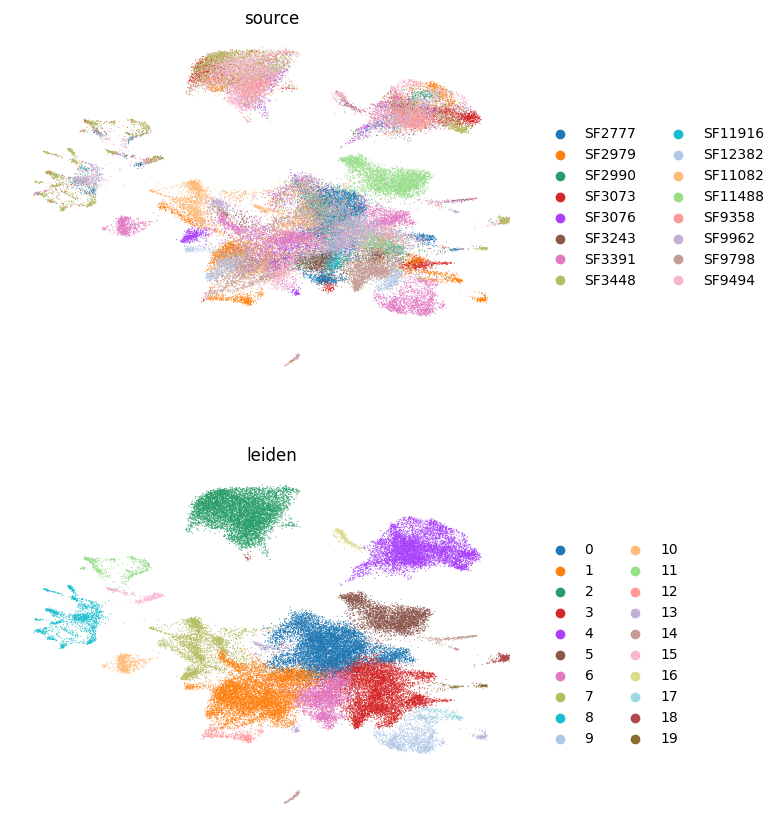

In [11]:
sc.tl.umap(adata, min_dist=0.5,random_state =0)
sc.pl.umap(
    adata,
    color=["source", "leiden"],
    frameon=False,
    ncols=1,
)

In [12]:
adata_singlet

View of AnnData object with n_obs × n_vars = 50738 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Cellid', 'Tumor_Normal_annotation', 'solo'
    var: 'Gene', 'mt', 'n_cells_by_counts-SF11082', 'mean_counts-SF11082', 'pct_dropout_by_counts-SF11082', 'total_counts-SF11082', 'n_cells_by_counts-SF11488', 'mean_counts-SF11488', 'pct_dropout_by_counts-SF11488', 'total_counts-SF11488', 'n_cells_by_counts-SF11916', 'mean_counts-SF11916', 'pct_dropout_by_counts-SF11916', 'total_counts-SF11916', 'n_cells_by_counts-SF12382', 'mean_counts-SF12382', 'pct_dropout_by_counts-SF12382', 'total_counts-SF12382', 'n_cells_by_counts-SF2777', 'mean_counts-SF2777', 'pct_dropout_by_counts-SF2777', 'total_counts-SF2777', 'n_cells_by_counts-SF2979', 'mean_counts-SF2979', 'pct_dropout_by_counts-SF2979', 'total_counts-SF2979', 'n_cells_by_counts-SF2990', 'mean_counts-SF2990', 'pct_dropout_by_counts-SF2990', 'to

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


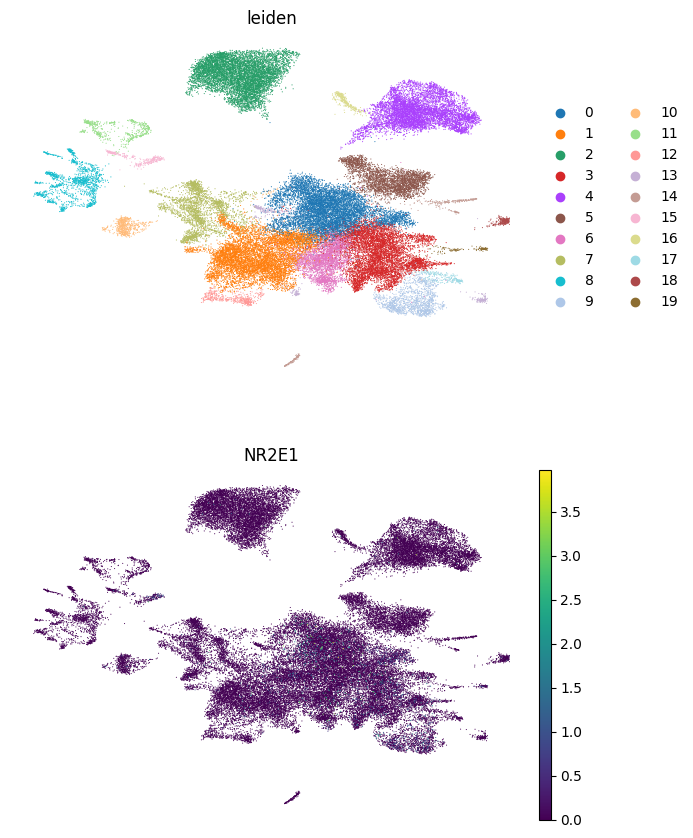

In [13]:
sc.pl.umap(
    adata_singlet,
    color=["leiden",'NR2E1'],
    frameon=False,
    ncols=1,
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:19)


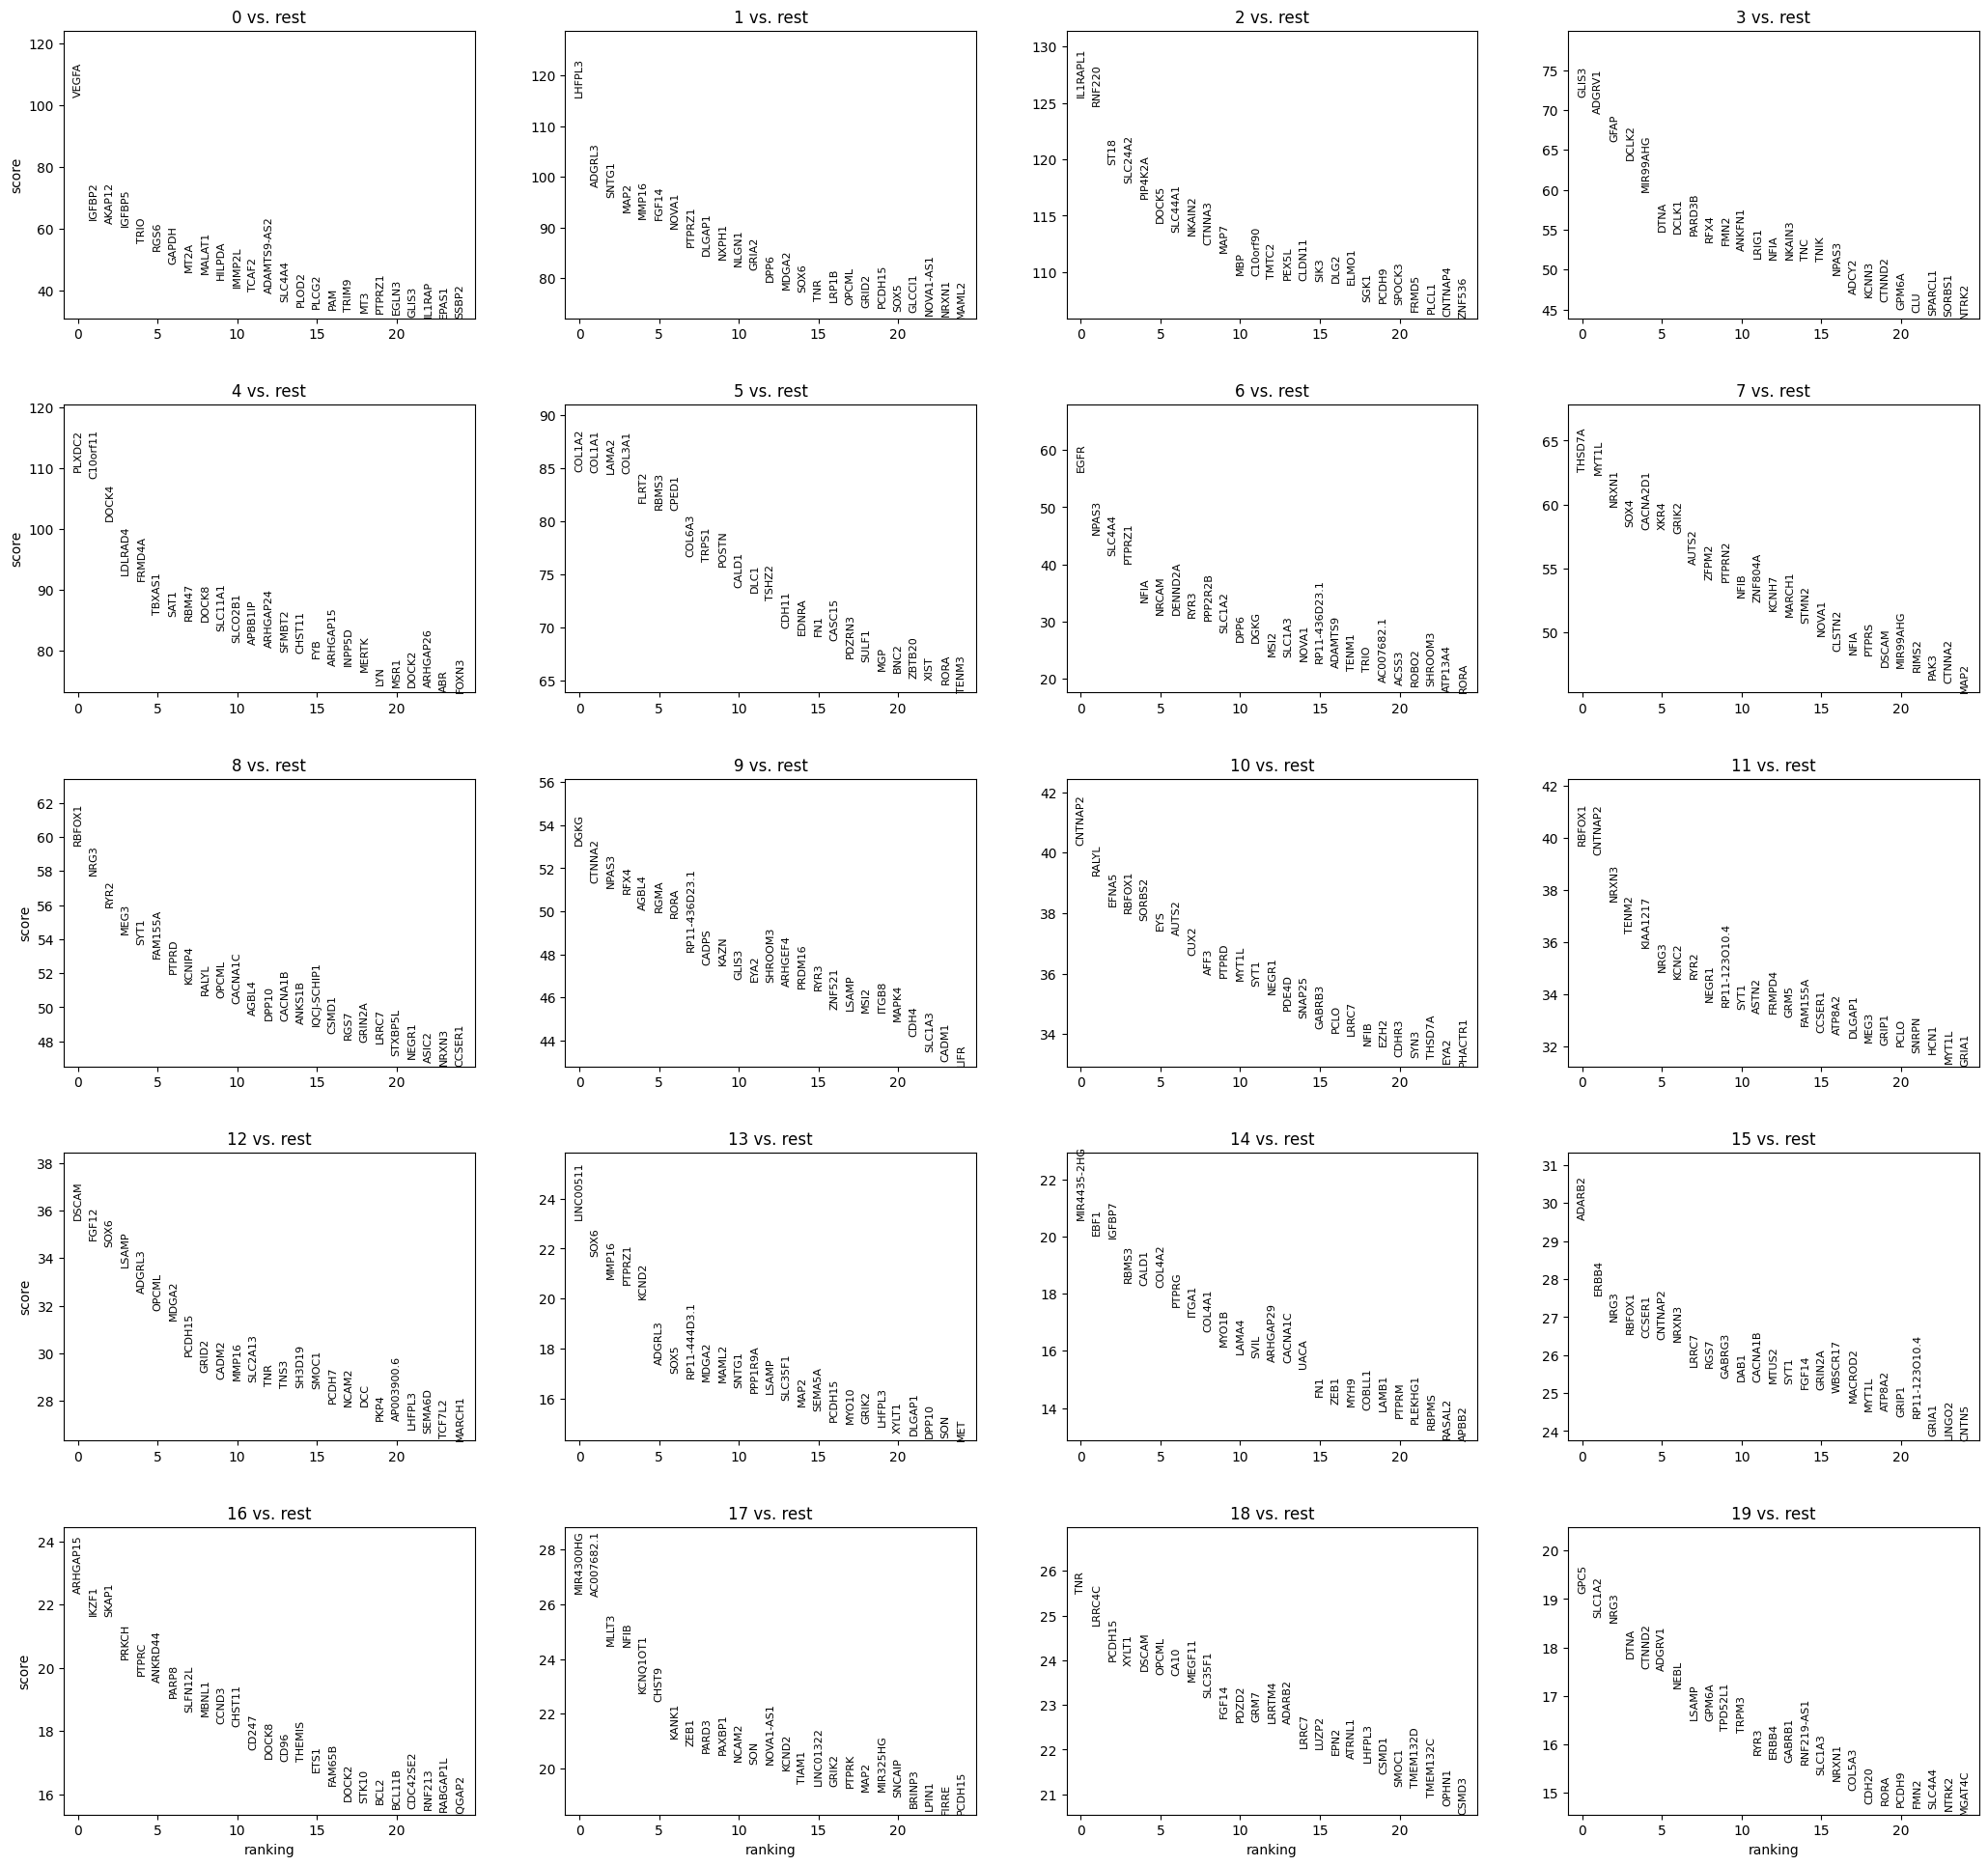

In [15]:
sc.tl.rank_genes_groups(adata_singlet, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_singlet, n_genes=25, sharey=False)

In [14]:
#only normal cells

adata_singlet_normal = adata_singlet[adata_singlet.obs['Tumor_Normal_annotation']=='Normal']

In [15]:
adata_singlet_normal

View of AnnData object with n_obs × n_vars = 16321 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', '_scvi_batch', '_scvi_labels', 'leiden', 'Cellid', 'Tumor_Normal_annotation', 'solo'
    var: 'Gene', 'mt', 'n_cells_by_counts-SF11082', 'mean_counts-SF11082', 'pct_dropout_by_counts-SF11082', 'total_counts-SF11082', 'n_cells_by_counts-SF11488', 'mean_counts-SF11488', 'pct_dropout_by_counts-SF11488', 'total_counts-SF11488', 'n_cells_by_counts-SF11916', 'mean_counts-SF11916', 'pct_dropout_by_counts-SF11916', 'total_counts-SF11916', 'n_cells_by_counts-SF12382', 'mean_counts-SF12382', 'pct_dropout_by_counts-SF12382', 'total_counts-SF12382', 'n_cells_by_counts-SF2777', 'mean_counts-SF2777', 'pct_dropout_by_counts-SF2777', 'total_counts-SF2777', 'n_cells_by_counts-SF2979', 'mean_counts-SF2979', 'pct_dropout_by_counts-SF2979', 'total_counts-SF2979', 'n_cells_by_counts-SF2990', 'mean_counts-SF2990', 'pct_dropout_by_counts-SF2990', 'to

In [16]:
sc.tl.paga(adata_singlet_normal)
sc.pl.paga(adata_singlet_normal, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_singlet_normal, init_pos='paga')

running PAGA


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/tools/_paga.py:132: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["paga"] = {}


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


In [17]:
sc.tl.umap(adata_singlet_normal)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


In [26]:
sc.tl.leiden(
    adata_singlet_normal,
    resolution=0.1,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


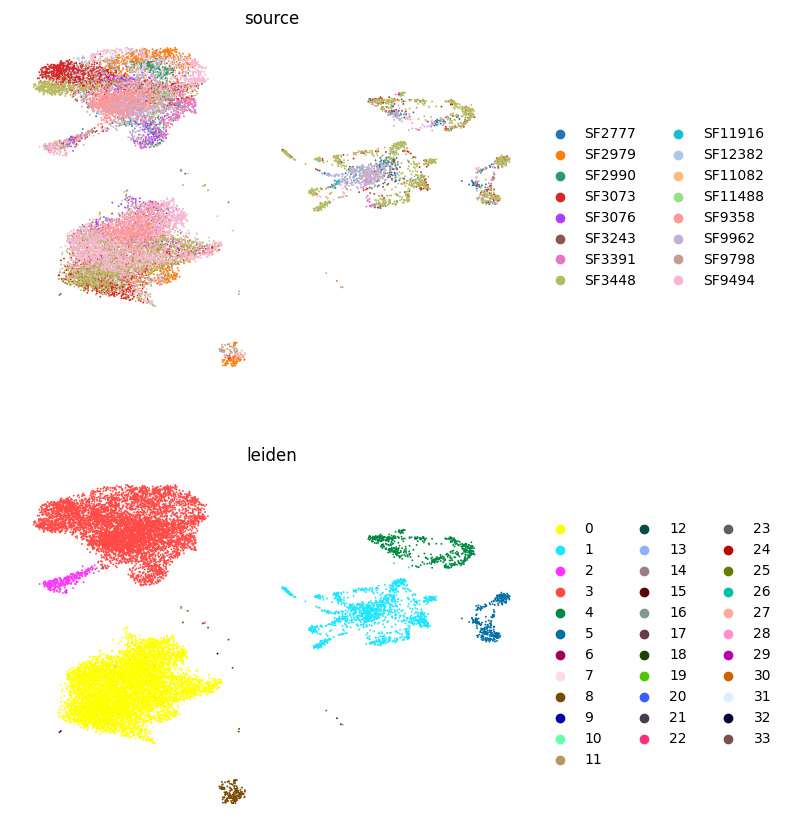

In [27]:
sc.pl.umap(
    adata_singlet_normal,
    color=["source", "leiden"],
    frameon=False,
    ncols=1
)

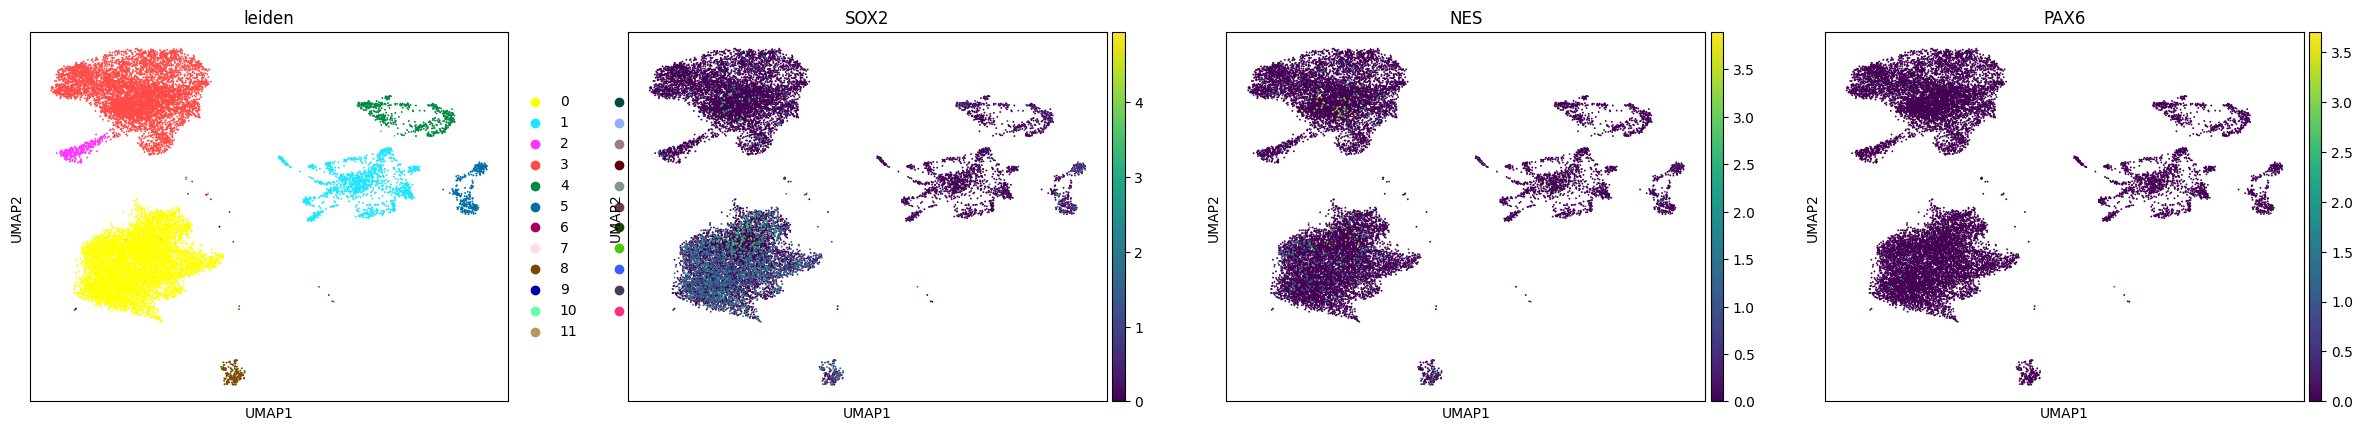

In [28]:
#NPC markers
sc.pl.umap(adata_singlet_normal,color=['leiden','SOX2','NES','PAX6'])

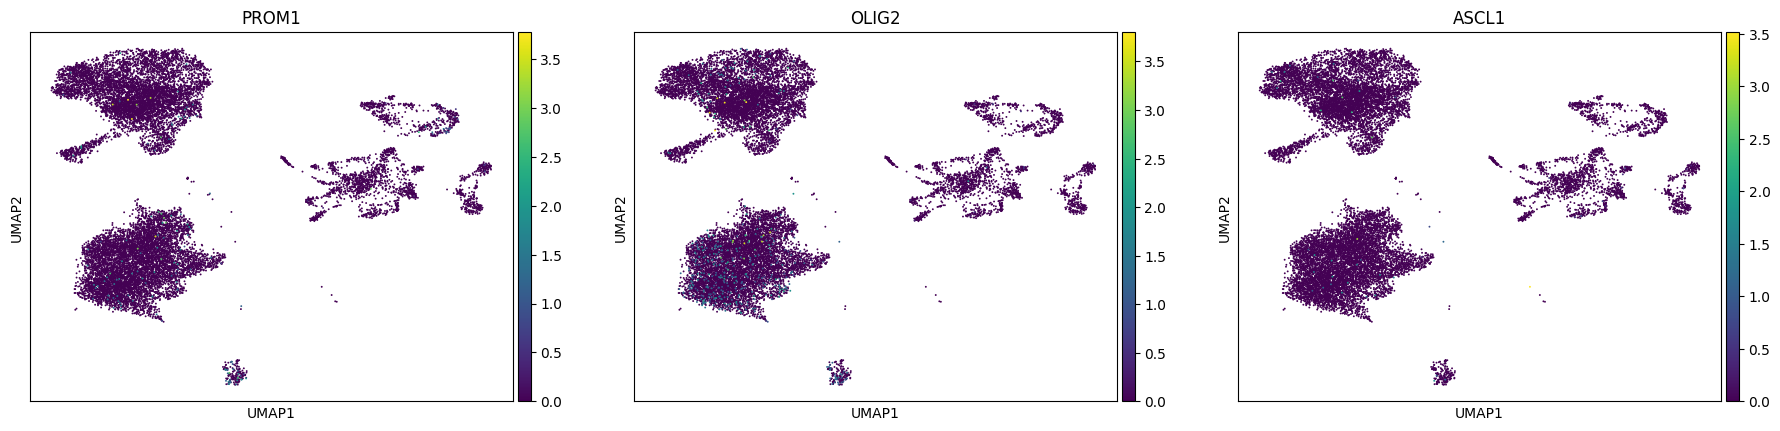

In [29]:
sc.pl.umap(adata_singlet_normal,color=['PROM1','OLIG2','ASCL1'])

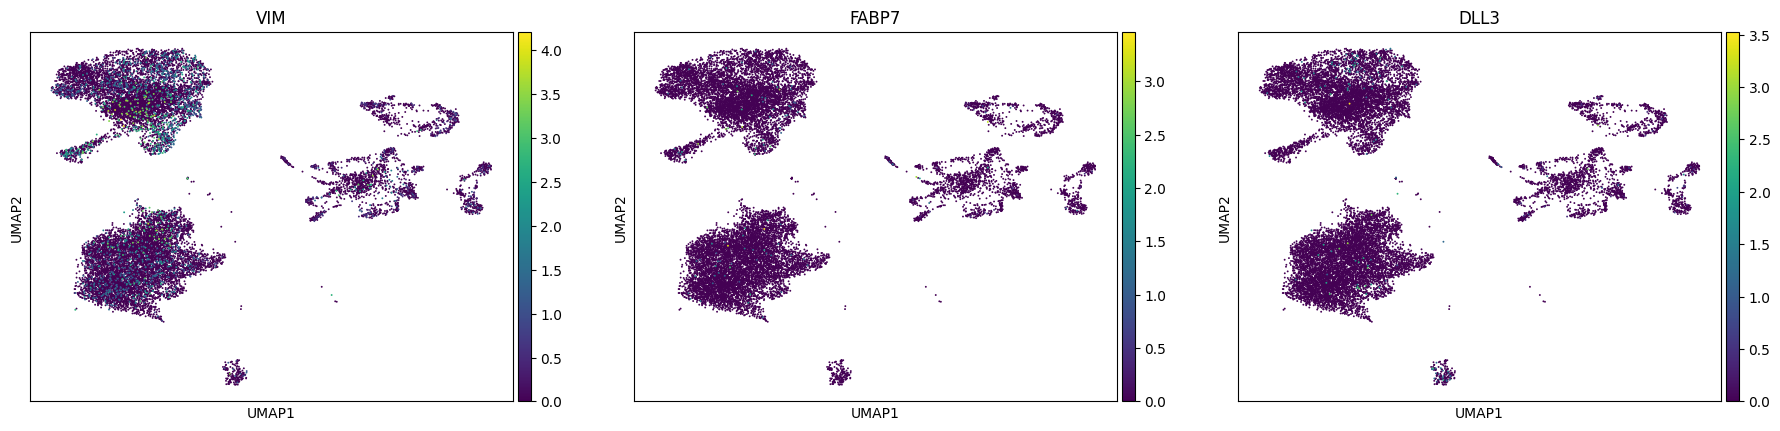

In [30]:
sc.pl.umap(adata_singlet_normal,color=['VIM','FABP7','DLL3'])

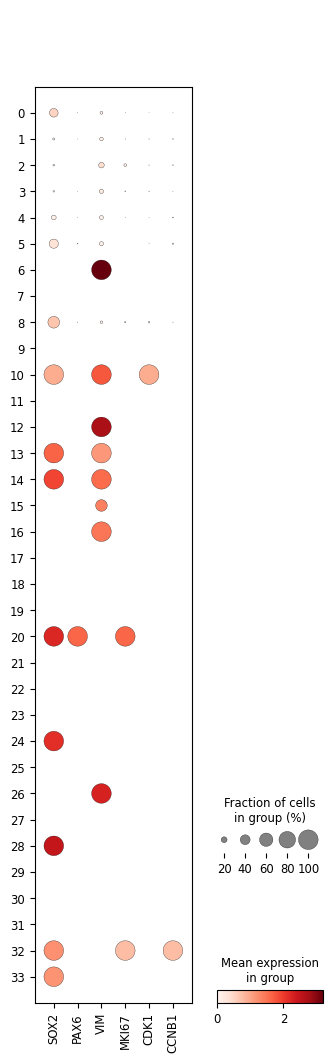

In [31]:
sc.pl.dotplot(adata_singlet_normal,['SOX2', 'PAX6', 'VIM','MKI67','CDK1','CCNB1'] , groupby="leiden")
